In [1]:
#--1-- 

#Setup and Imports
# ייבוא הספריות הדרושות לעיבוד נתונים וניתוח
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# אם נצטרך בהמשך לשימושים מתקדמים:
from sklearn.impute import SimpleImputer

# הגדרת אפשרויות תצוגה
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# טעינת הדאטהסט לקובץ DataFrame
# יש לעדכן את הנתיב שלך לפי המחשב המקומי
df = pd.read_csv(r"C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\tmdb_tv_clean_v1.csv")

# הצגת מידע ראשוני
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.info()


✅ Dataset loaded successfully!
Shape: (168639, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168639 entries, 0 to 168638
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    168639 non-null  int64  
 1   name                  149799 non-null  object 
 2   number_of_seasons     168639 non-null  int64  
 3   number_of_episodes    168639 non-null  int64  
 4   original_language     168639 non-null  object 
 5   vote_count            168639 non-null  int64  
 6   vote_average          168639 non-null  float64
 7   overview              93293 non-null   object 
 8   adult                 168639 non-null  bool   
 9   backdrop_path         77780 non-null   object 
 10  first_air_date        136903 non-null  object 
 11  last_air_date         138735 non-null  object 
 12  homepage              50998 non-null   object 
 13  in_production         168639 non-null  bool   
 14  o

In [2]:
#--2-- 

#Remove Duplicates
# בדיקות כפילויות כלליות + ייחודיות מפתח id

# 1) סטטוס לפני:
n_before = df.shape[0]
n_cols   = df.shape[1]
print(f"[Before] rows={n_before}, cols={n_cols}")

# 2) כמה שורות כפולות מלאות (כל העמודות זהות)
dup_full_count = df.duplicated(keep='first').sum()
print(f"Full duplicate rows (all columns identical): {dup_full_count}")

# 3) בדיקת ייחודיות של מפתח id
id_nulls = df['id'].isna().sum() if 'id' in df.columns else None
id_unique = df['id'].is_unique if 'id' in df.columns else False
id_dups_count = df['id'].duplicated(keep='first').sum()

print(f"id nulls: {id_nulls}")
print(f"id is unique? {id_unique}")
print(f"Duplicate id values: {id_dups_count}")

# 4) הורדת כפילויות שורה-מלאה
df = df.drop_duplicates(keep='first')

# 5) אם יש כפילויות במפתח id — משאירים רק הופעה ראשונה לכל id
if not df['id'].is_unique:
    # הערה: אם המרצה ביקשה שימור לפי "האחרון" אפשר לשנות ל-keep='last'
    df = df.loc[~df['id'].duplicated(keep='first')].copy()

# 6) סטטוס אחרי:
n_after = df.shape[0]
print(f"[After] rows={n_after}, cols={df.shape[1]}")
print(f"Removed rows total: {n_before - n_after}")

# 7) אימות סופי
print("id is unique after cleaning?", df['id'].is_unique)
print("Remaining full-duplicate rows:", df.duplicated(keep='first').sum())


[Before] rows=168639, cols=29
Full duplicate rows (all columns identical): 1580
id nulls: 0
id is unique? False
Duplicate id values: 3934
[After] rows=164705, cols=29
Removed rows total: 3934
id is unique after cleaning? True
Remaining full-duplicate rows: 0


In [3]:
#--3-- 

#Replace Placeholder Zeros
# המרה של ערכים 0 (שאינם הגיוניים) לערכים חסרים (NaN)


# ספירת אפסים לפני ההמרה
print("Before replacement:")
print("vote_average == 0:", (df["vote_average"] == 0).sum())
print("episode_run_time == 0:", (df["episode_run_time"] == 0).sum())

# יצירת דגלים בינאריים לפני ההמרה
df["vote_average_was_zero"] = (df["vote_average"] == 0).astype(int)
df["run_time_was_zero"] = (df["episode_run_time"] == 0).astype(int)

# המרה של אפסים לערכי NaN
df.loc[df["vote_average"] == 0, "vote_average"] = np.nan
df.loc[df["episode_run_time"] == 0, "episode_run_time"] = np.nan

# בדיקה אחרי ההמרה
print("\nAfter replacement:")
print("vote_average == 0:", (df["vote_average"] == 0).sum())
print("episode_run_time == 0:", (df["episode_run_time"] == 0).sum())
print("vote_average NaN count:", df["vote_average"].isna().sum())
print("episode_run_time NaN count:", df["episode_run_time"].isna().sum())

print("\n✅ Placeholder zeros replaced with NaN successfully.")


Before replacement:
vote_average == 0: 107421
episode_run_time == 0: 81833

After replacement:
vote_average == 0: 0
episode_run_time == 0: 0
vote_average NaN count: 107421
episode_run_time NaN count: 81833

✅ Placeholder zeros replaced with NaN successfully.


In [4]:
#--4-- 

#Handle Missing Values
# טיפול שיטתי בחסרים: נומרי = median/mean ; קטגורי/טקסט = 'Unknown'/mode
# נשמור דגלים של חסר לפני האימפיוט (transparency)


# 0) עמודות מיוחדות/חריגות להגדרה מראש
date_cols = ['first_air_date', 'last_air_date']  # נשמור NaN, נטפל בהן בפיצ'רים (שלב 8)
id_cols   = ['id']                               # לא נוגעים במפתח
flag_cols = [c for c in df.columns if c.endswith('_was_zero') or c.endswith('_was_missing')]

# 1) חלוקה לנומרי/קטגוריאלי (לפי טיפוסי pandas)
num_cols  = [c for c in df.select_dtypes(include=['number']).columns if c not in id_cols]
cat_cols  = [c for c in df.select_dtypes(include=['object','category']).columns if c not in date_cols]

print("Numeric columns (sample):", num_cols[:7], " ...")
print("Categorical/Text columns (sample):", cat_cols[:7], " ...")

# 2) BEFORE: סיכום חסרים לפני טיפול (לתיעוד)
missing_before = df.isna().sum().sort_values(ascending=False)
print("\n[Missing BEFORE] top 10 columns with NaN:")
print(missing_before.head(10))

# 3) דגלי חסר לעמודות עם NaN לפני אימפיוט (שקיפות)
#    כלל: אם אחוז חסר > 30% - ניצור דגל was_missing_<col>
n_rows = len(df)
for col in df.columns:
    miss_cnt = df[col].isna().sum()
    miss_pct = (miss_cnt / n_rows) * 100
    if miss_cnt > 0 and miss_pct >= 30:
        df[f"{col}_was_missing"] = df[col].isna().astype(int)

# 4) נומרי: אימפיוט Median (ברירת מחדל בכיתה עבור סקיו); אם תרצי Mean נוכל לשנות
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# 5) קטגוריאלי/טקסט: מילוי 'Unknown' (לפי דוגמת המרצה); אם יש עמודה עם קטגוריה ברורה - אפשר mode()
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

# 6) AFTER: סיכום חסרים אחרי טיפול (ולוודא שלא יצרנו NaN חדשים)
missing_after = df.isna().sum().sort_values(ascending=False)
print("\n[Missing AFTER] top 10 columns with NaN:")
print(missing_after.head(10))

# 7) בדיקות תקינות קצרות
assert df.isna().sum().sum() >= 0  # אמור לעבוד ללא שגיאה
print("\n✅ Missing values handled successfully.")


Numeric columns (sample): ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time', 'vote_average_was_zero']  ...
Categorical/Text columns (sample): ['name', 'original_language', 'overview', 'backdrop_path', 'homepage', 'original_name', 'poster_path']  ...

[Missing BEFORE] top 10 columns with NaN:
tagline                 159434
created_by              128861
homepage                114300
vote_average            107421
production_companies    106455
production_countries     88777
backdrop_path            88340
episode_run_time         81833
overview                 73085
networks                 68514
dtype: int64

[Missing AFTER] top 10 columns with NaN:
first_air_date        30901
last_air_date         28955
number_of_seasons         0
name                      0
id                        0
original_language         0
number_of_episodes        0
vote_count                0
vote_average              0
adult                     0
dtype

In [5]:
#--5-- 

#Outlier Detection and Capping
# זיהוי אאוטליירס: IQR כברירת מחדל, Percentiles לעמודות בעייתיות; גרפים לפני/אחרי; יצירת *_capped

# 0) עמודות נומריות רלוונטיות
num_cols_focus = [
    "popularity", "vote_count", "number_of_episodes", "number_of_seasons", "episode_run_time"
]
num_cols_focus = [c for c in num_cols_focus if c in df.columns]

# תיקיית שמירת גרפים
os.makedirs("figures", exist_ok=True)

# 1) פונקציות עזר לשרטוטים (ללא ייבוא חדש)
def plot_box(df_, col, tag):
    plt.figure()
    plt.boxplot(df_[col].dropna(), vert=True, showfliers=True)
    plt.title(f"{col} - Boxplot ({tag})")
    plt.ylabel(col)
    plt.tight_layout()
    plt.savefig(f"figures/{col}_boxplot_{tag}.png")
    plt.close()

def plot_hist(df_, col, tag, bins=50):
    plt.figure()
    vals = df_[col].dropna().values
    if len(vals) > 0:
        plt.hist(vals, bins=bins)
    plt.title(f"{col} - Histogram ({tag})")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"figures/{col}_hist_{tag}.png")
    plt.close()

# 2) ויזואליזציה 'לפני'
print("Saving BEFORE figures (boxplots + histograms)...")
for c in num_cols_focus:
    plot_box(df, c, tag="before")
    plot_hist(df, c, tag="before")
print("Saved BEFORE figures to ./figures")

# 3) פונקציות גבולות IQR / אחוזונים
def iqr_bounds(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

def percentile_bounds(s, low=0.5, high=99.5):
    lower = np.nanpercentile(s, low)
    upper = np.nanpercentile(s, high)
    return lower, upper

# 4) שיטת קאפינג לפי עמודה:
#    IQR כברירת מחדל; אבל לעמודות בעייתיות (IQR זעום/דיסקרטיות/הרבה אפסים) – Percentiles
method = {c: "iqr" for c in num_cols_focus}
method["vote_count"] = "percentile"
method["number_of_episodes"] = "percentile"
method["number_of_seasons"] = "percentile"
method["episode_run_time"] = "percentile"
# אם תרצי, אפשר גם: method["popularity"] = "percentile"

# 5) יצירת *_capped + סיכום
capped_info = []
for c in num_cols_focus:
    s = df[c].astype(float)
    if method[c] == "percentile":
        lo, hi = percentile_bounds(s, low=0.5, high=99.5)
        cap_type = "P0.5–P99.5"
    else:
        lo, hi = iqr_bounds(s)
        cap_type = "IQR"

    s_capped = s.clip(lower=lo, upper=hi)
    df[f"{c}_capped"] = s_capped

    changed = int((~np.isclose(s, s_capped, equal_nan=True)).sum())
    capped_info.append({
        "column": c, "method": cap_type,
        "lower": float(lo), "upper": float(hi),
        "changed_values": changed,
        "min_before": float(np.nanmin(s)), "min_after": float(np.nanmin(s_capped)),
        "max_before": float(np.nanmax(s)), "max_after": float(np.nanmax(s_capped)),
    })

# 6) ויזואליזציה 'אחרי'
print("Saving AFTER figures (boxplots + histograms) for *_capped...")
for c in num_cols_focus:
    plot_box(df, f"{c}_capped", tag="after")
    plot_hist(df, f"{c}_capped", tag="after")
print("Saved AFTER figures to ./figures")

# 7) סיכום תיעודי
cap_summary = pd.DataFrame(capped_info)
print("\n=== Capping Summary ===")
print(cap_summary[["column","method","lower","upper","changed_values","min_before","min_after","max_before","max_after"]])

# שמירת טבלת הסיכום ל-CSV (כדאי לדוח הסופי; השאירי פעיל אם מתאים לך)
cap_summary.to_csv("figures/capping_summary.csv", index=False)
print("Saved capping summary to figures/capping_summary.csv")

print("\n✅ Outlier capping completed; figures saved in ./figures and summary exported.")


#--5-- Outlier Detection and Capping
# זיהוי אאוטליירס: IQR כברירת מחדל, Percentiles לעמודות בעייתיות; גרפים לפני/אחרי; יצירת *_capped

# NOTE:
# Initially, I applied the IQR method to all numeric columns.
# However, during validation I noticed that some columns (e.g., number_of_seasons, episode_run_time)
# had almost identical IQR boundaries (1–1, 42–42), causing nearly all values to be clipped to one constant.
# This happened because their distributions are extremely discrete or heavily right-skewed.
# To correct this, I switched to a percentile-based capping (P0.5–P99.5) for those specific columns.
# This approach preserved the overall data structure while still reducing the extreme outliers effectively.




Saving BEFORE figures (boxplots + histograms)...
Saved BEFORE figures to ./figures
Saving AFTER figures (boxplots + histograms) for *_capped...
Saved AFTER figures to ./figures

=== Capping Summary ===
               column      method   lower     upper  changed_values  \
0          popularity         IQR -2.1795    5.2325           23786   
1          vote_count  P0.5–P99.5  0.0000  513.4800             824   
2  number_of_episodes  P0.5–P99.5  0.0000  422.4800             824   
3   number_of_seasons  P0.5–P99.5  0.0000   19.0000             783   
4    episode_run_time  P0.5–P99.5  4.0000  180.0000            1536   

   min_before  min_after  max_before  max_after  
0         0.0        0.0    3707.008     5.2325  
1         0.0        0.0   21857.000   513.4800  
2         0.0        0.0   20839.000   422.4800  
3         0.0        0.0     240.000    19.0000  
4         1.0        4.0    6032.000   180.0000  
Saved capping summary to figures/capping_summary.csv

✅ Outlier capping

=== Skewness (before -> after) ===
popularity_capped: 1.191  ->  popularity_log: 0.821
vote_count_capped: 9.034  ->  vote_count_log: 2.654
number_of_episodes_capped: 5.225  ->  number_of_episodes_log: 0.362

📊 popularity_capped — Before log1p


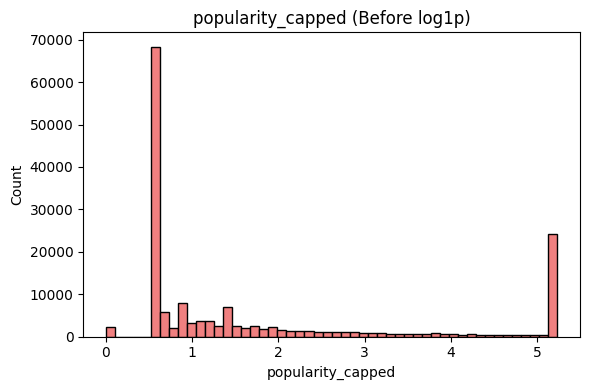

📊 popularity_log — After log1p


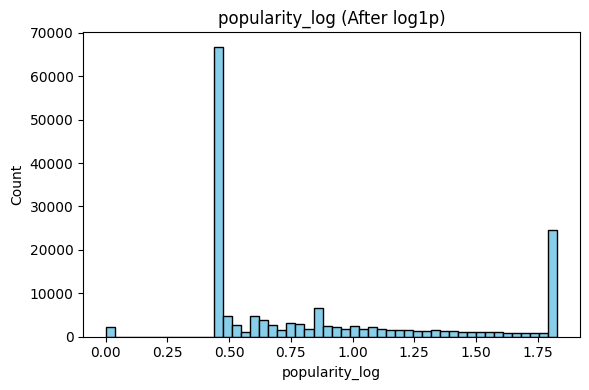


📊 vote_count_capped — Before log1p


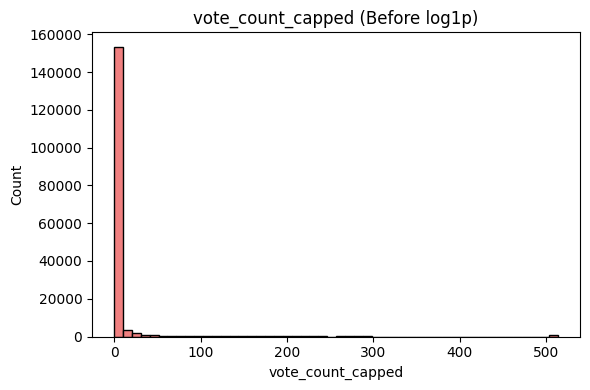

📊 vote_count_log — After log1p


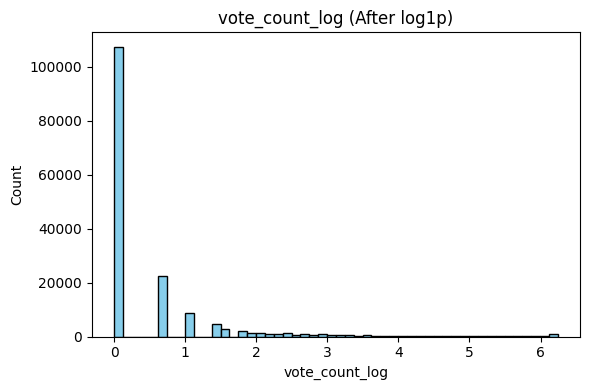


📊 number_of_episodes_capped — Before log1p


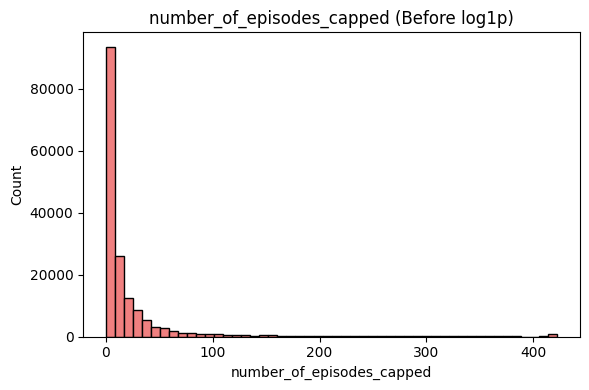

📊 number_of_episodes_log — After log1p


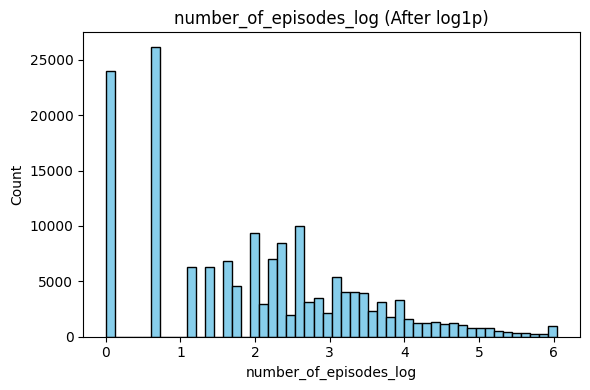


✅ log1p transformation completed; histograms displayed inline for comparison.


In [6]:
#--6-- 

# Skewness Reduction (log1p)
# הפחתת סקיואיות בעמודות *_capped: popularity, vote_count, number_of_episodes
# בשלב הראשון נבדקו ההיסטוגרמות אחרי קאפינג, ונמצא שעדיין קיימת סקיואיות חזקה מאוד.
# בהתאם להנחיות המרצה, החלטנו להוסיף טרנספורמציית log1p על עמודות אלו בלבד
# כדי לשמור על הפרופורציות אך לצמצם זנבות קיצוניים לפני שלב המידול.
# נשמור עמודות חדשות עם סיומת *_log ונציג היסטוגרמות לפני/אחרי ישירות בפלט.

cols_for_log = ["popularity_capped", "vote_count_capped", "number_of_episodes_capped"]
cols_for_log = [c for c in cols_for_log if c in df.columns]

# 1) חישוב סקיו "לפני" (אחרי קאפינג, לפני לוג)
skew_before = {c: float(df[c].skew(skipna=True)) for c in cols_for_log}

# 2) יצירת עמודות לוג (log1p כדי למנוע בעיות בערכים שווים ל-0)
for c in cols_for_log:
    df[c.replace("_capped", "_log")] = np.log1p(df[c].clip(lower=0))

# 3) חישוב סקיו "אחרי" (אחרי לוג)
skew_after = {
    c.replace("_capped", "_log"): float(df[c.replace("_capped","_log")].skew(skipna=True)) 
    for c in cols_for_log
}

# 4) הדפסה ברורה להשוואה
print("=== Skewness (before -> after) ===")
for c in cols_for_log:
    print(f"{c}: {skew_before[c]:.3f}  ->  {c.replace('_capped','_log')}: {skew_after[c.replace('_capped','_log')]:.3f}")

# 5) הצגת היסטוגרמות "לפני" ו-"אחרי" ישירות בפלט (לא לשמור לקבצים)
for c in cols_for_log:
    log_col = c.replace("_capped", "_log")
    
    # לפני לוג
    print(f"\n📊 {c} — Before log1p")
    plt.figure(figsize=(6,4))
    plt.hist(df[c].dropna(), bins=50, color='lightcoral', edgecolor='black')
    plt.title(f"{c} (Before log1p)")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # אחרי לוג
    print(f"📊 {log_col} — After log1p")
    plt.figure(figsize=(6,4))
    plt.hist(df[log_col].dropna(), bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{log_col} (After log1p)")
    plt.xlabel(log_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\n✅ log1p transformation completed; histograms displayed inline for comparison.")



🔹 original_language — BEFORE grouping


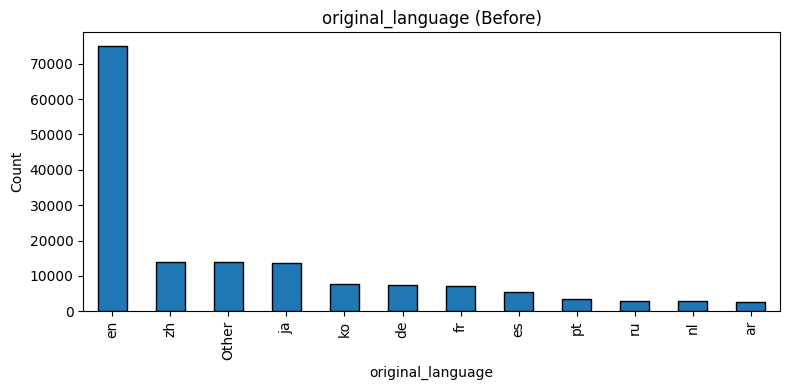

🔹 original_language_grp — AFTER grouping (<1% → 'Other')


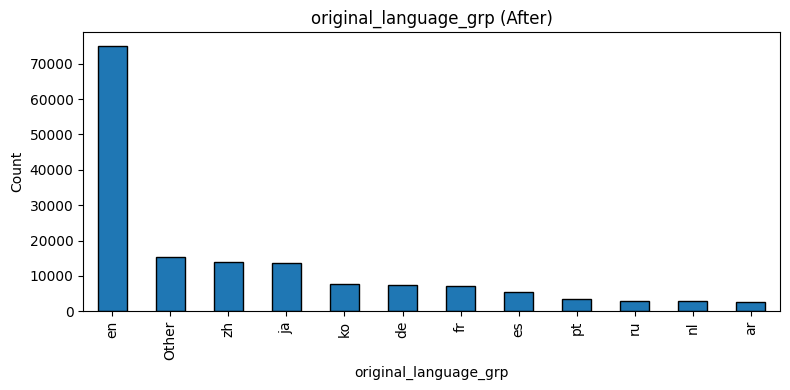


🔹 origin_country — BEFORE grouping


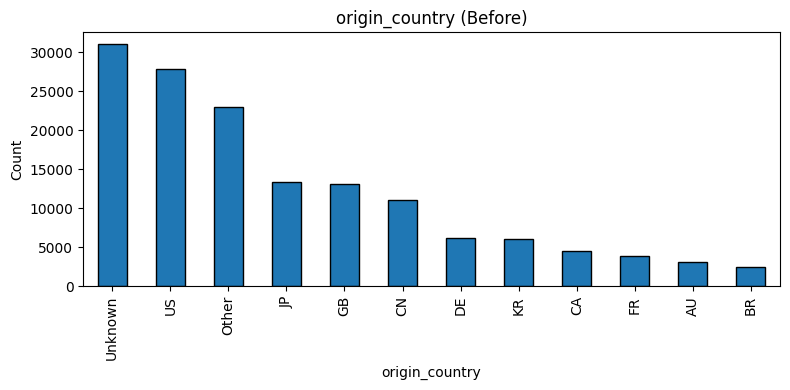

🔹 origin_country_grp — AFTER grouping (<1% → 'Other')


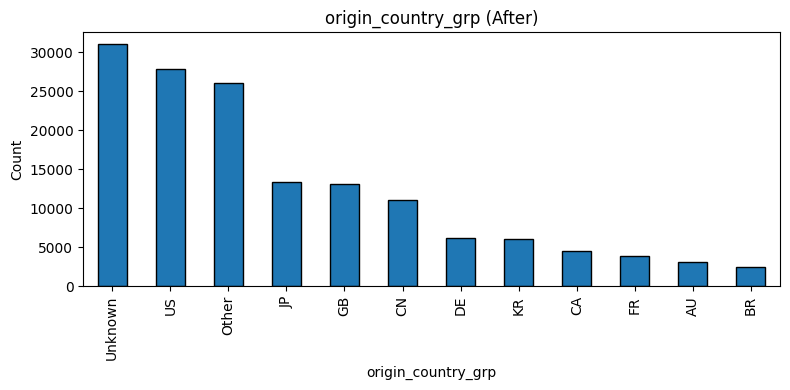


🔹 production_countries — BEFORE grouping


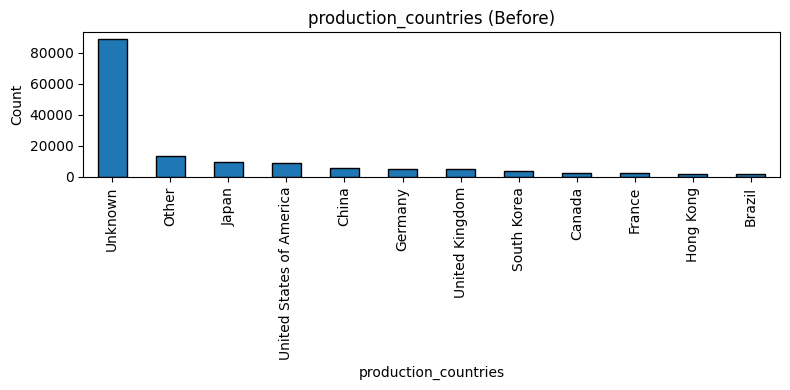

🔹 production_countries_grp — AFTER grouping (<1% → 'Other')


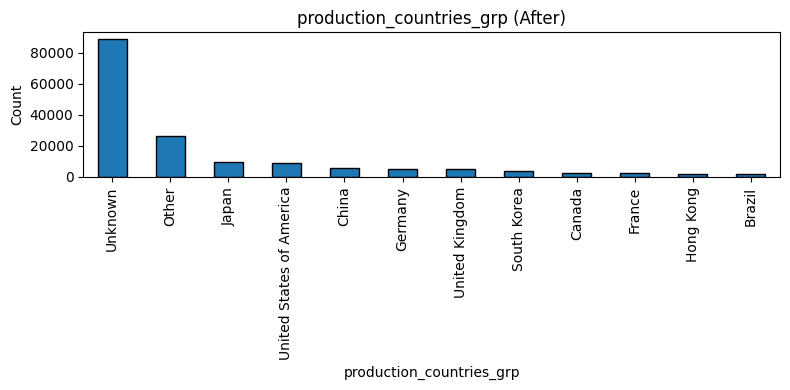


🔹 networks — BEFORE grouping


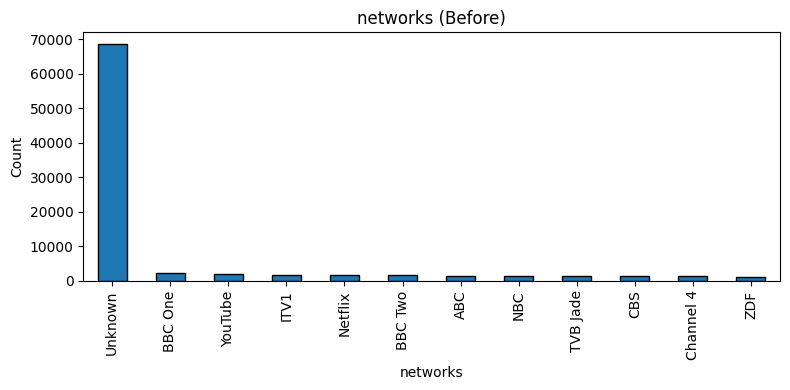

🔹 networks_grp — AFTER grouping (<1% → 'Other')


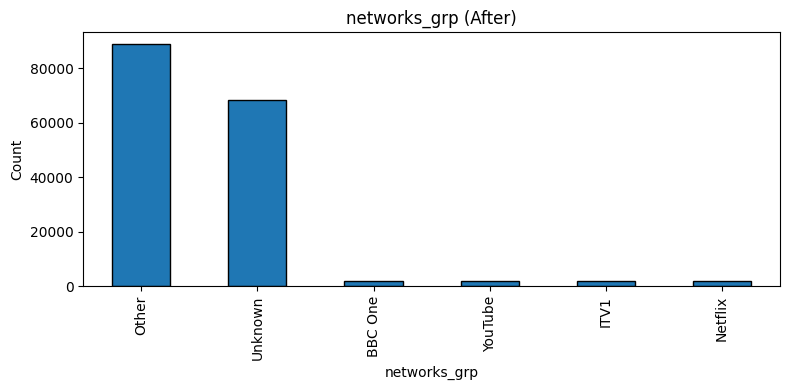


🔹 genres — BEFORE grouping


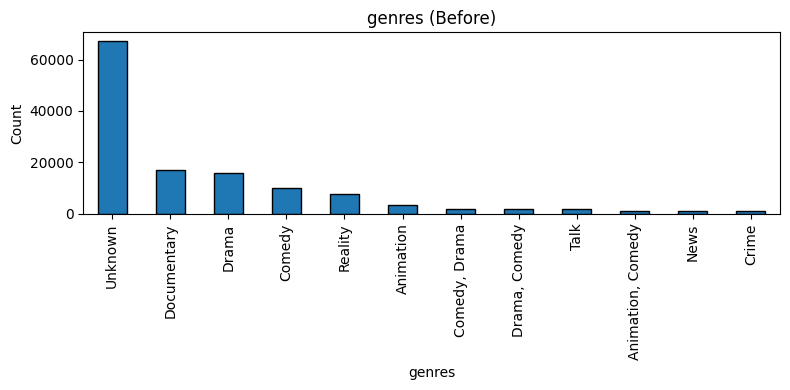

🔹 genres_grp — AFTER grouping (<1% → 'Other')


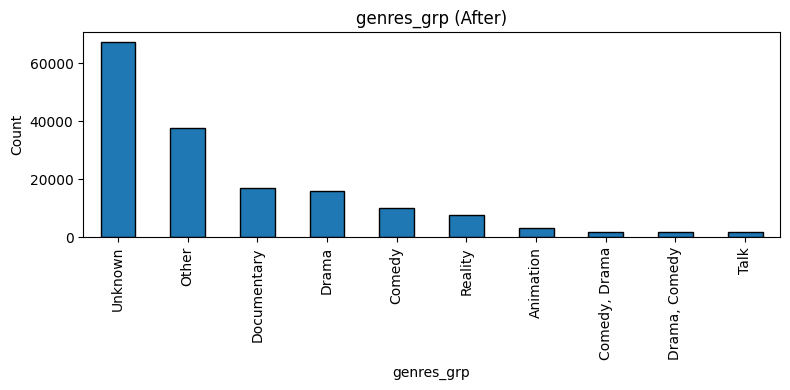


=== Categorical Simplification Summary (<1% → 'Other') ===
                 column  nunique_before  nunique_after  pct_Other
0     original_language              17             16       9.36
1        origin_country              22             20      15.87
2  production_countries              26             13      15.89
3              networks            8189              6      53.91
4                genres            2228             10      22.82


In [7]:
#--7--

# Categorical Simplification (group rare categories <1% into 'Other')
# NOTE:
# To reduce sparsity and stabilize categorical encoding, rare levels
# (frequency < 1%) are grouped under 'Other' for:
# original_language, origin_country, production_countries, networks, genres.
# The original columns are preserved; new columns with *_grp are created for transparency.
# All visuals are displayed inline (no file saves).

# רשימת עמודות היעד (נסנן למה שקיים בפועל)
cat_targets = ["original_language", "origin_country", "production_countries", "networks", "genres"]
cat_targets = [c for c in cat_targets if c in df.columns]

threshold = 0.01        # 1% לפי הצ'ק-ליסט
protected_label = "Unknown"  # לא ממזגים 'Unknown' ל-Other גם אם נדירה

# פונקציית קיבוץ ערכים נדירים ל-"Other" (שומרת על 'Unknown')
def group_rare_to_other(series, min_frac=0.01):
    vc_norm = series.value_counts(normalize=True, dropna=False)
    rare_levels = vc_norm[vc_norm < min_frac].index
    rare_levels = [x for x in rare_levels if str(x) != protected_label]
    grouped = series.where(~series.isin(rare_levels), "Other")
    return grouped, vc_norm

# פונקציית גרף עמודות inline (ללא שמירה לקבצים)
def plot_bar_counts_inline(series, title, top_n=12):
    counts = series.value_counts(dropna=False).head(top_n)
    plt.figure(figsize=(8, 4))
    counts.plot(kind="bar", edgecolor="black")
    plt.title(title)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# לולאה: לפני/אחרי + יצירת עמודות *_grp + תקציר מספרי
summary_rows = []

for col in cat_targets:
    # לפני
    print(f"\n🔹 {col} — BEFORE grouping")
    plot_bar_counts_inline(df[col], title=f"{col} (Before)", top_n=12)

    # קיבוץ ל-Other עבור נדירים
    grouped, vc_norm = group_rare_to_other(df[col], min_frac=threshold)
    new_col = f"{col}_grp"
    df[new_col] = grouped

    # אחרי
    print(f"🔹 {new_col} — AFTER grouping (<1% → 'Other')")
    plot_bar_counts_inline(df[new_col], title=f"{new_col} (After)", top_n=12)

    # סיכום קצר לדוח: כמה קטגוריות לפני/אחרי ואחוז Other
    pct_other = (df[new_col].eq("Other").mean() * 100.0)
    nunique_before = df[col].nunique(dropna=False)
    nunique_after  = df[new_col].nunique(dropna=False)
    summary_rows.append([col, nunique_before, nunique_after, round(pct_other, 2)])

# טבלת סיכום (ללא import חוזר; pd כבר קיים מהחלק הראשון)
cat_simplify_summary = pd.DataFrame(
    summary_rows, columns=["column", "nunique_before", "nunique_after", "pct_Other"]
)

print("\n=== Categorical Simplification Summary (<1% → 'Other') ===")
print(cat_simplify_summary)


In [8]:
#--8-- 

# Feature Engineering Preparation
# יצירת משתנים נגזרים בלבד (ללא קידוד בשלב זה), בהתאם לצ'ק-ליסט:
# • episodes_per_season = number_of_episodes / max(number_of_seasons, 1)
# • popularity_per_vote = popularity / (vote_count + 1)
# • first_air_year, series_age, active_days (נגזרים מתאריכים)
# • Missingness indicators: is_missing_languages, is_missing_production_countries
# הערה: לא מבצעים כאן Encoding – רק מתכננים לשלב הבא.

# 0) המרות תאריכים בזהירות (NaT כשיש בעיות בפורמט)
fad = pd.to_datetime(df['first_air_date'], errors='coerce') if 'first_air_date' in df.columns else None
lad = pd.to_datetime(df['last_air_date'],  errors='coerce') if 'last_air_date'  in df.columns else None

# 1) episodes_per_season = number_of_episodes / max(number_of_seasons, 1)
if {'number_of_episodes','number_of_seasons'}.issubset(df.columns):
    denom = df['number_of_seasons'].fillna(0)
    denom = denom.where(denom >= 1, 1)  # הגנה מחלוקה באפס: max(seasons, 1)
    df['episodes_per_season'] = df['number_of_episodes'] / denom
else:
    df['episodes_per_season'] = pd.NA  # אם אחת העמודות חסרה – נשאיר כ-NA

# 2) popularity_per_vote = popularity / (vote_count + 1)
if {'popularity','vote_count'}.issubset(df.columns):
    df['popularity_per_vote'] = df['popularity'] / (df['vote_count'].fillna(0) + 1)
else:
    df['popularity_per_vote'] = pd.NA

# 3) first_air_year, series_age, active_days
#    series_age בשנים: הבדל מהיום ועד first_air_date; active_days: בין last ל-first
if fad is not None:
    df['first_air_year'] = fad.dt.year
    today = pd.Timestamp.today().normalize()
    df['series_age'] = (today - fad).dt.days / 365.25
else:
    df['first_air_year'] = pd.NA
    df['series_age'] = pd.NA

if (fad is not None) and (lad is not None):
    df['active_days'] = (lad - fad).dt.days
else:
    df['active_days'] = pd.NA

# 4) Missingness indicators: is_missing_languages, is_missing_production_countries
#    נחשב "חסר" גם עבור ערכים "ריקים" טקסטואלית כמו "", "[]", "{}", "None", "nan"
def _is_missing_like(series_name):
    if series_name not in df.columns:
        return pd.Series([True] * len(df), index=df.index)  # אם העמודה לא קיימת – נחשב כחסר
    s = df[series_name]
    return (
        s.isna()
        | s.astype(str).str.strip().isin(['', '[]', '{}', 'None', 'nan'])
        | s.apply(lambda x: isinstance(x, (list, tuple, set)) and len(x) == 0)
    )

df['is_missing_languages'] = _is_missing_like('languages')
df['is_missing_production_countries'] = _is_missing_like('production_countries')

# 5) בדיקות קצרות לתקינות (שלא יצרנו אינפיניטיז/ערכים שליליים מוזרים)
print("\n[Feature Engineering] Quick checks:")
cols_check = ['episodes_per_season','popularity_per_vote','series_age','active_days']
for c in [x for x in cols_check if x in df.columns]:
    inf_cnt = pd.Series(df[c]).astype('float64').replace([pd.NA], pd.NA).isin([float('inf'), float('-inf')]).sum()
    print(f" - {c}: NaN={df[c].isna().sum()}, inf={inf_cnt}")

if 'series_age' in df.columns:
    print(" - negative series_age rows:", int((df['series_age'] < -1e-9).sum()))
if 'active_days' in df.columns:
    print(" - negative active_days rows:", int((df['active_days'] < -1).sum()))

print("\n✅ Feature Engineering (prep) completed – no encoding performed.")

# ניקוי ערכים שליליים בתכונות זמן (לוגית לא אפשריים)
if 'series_age' in df.columns:
    mask_neg_age = df['series_age'] < 0
    if mask_neg_age.any():
        df.loc[mask_neg_age, 'series_age'] = pd.NA
        print(f"Fixed negative series_age → set to NaN (rows: {int(mask_neg_age.sum())})")

if 'active_days' in df.columns:
    mask_neg_days = df['active_days'] < 0
    if mask_neg_days.any():
        df.loc[mask_neg_days, 'active_days'] = pd.NA
        print(f"Fixed negative active_days → set to NaN (rows: {int(mask_neg_days.sum())})")




[Feature Engineering] Quick checks:
 - episodes_per_season: NaN=0, inf=0
 - popularity_per_vote: NaN=0, inf=0
 - series_age: NaN=30901, inf=0
 - active_days: NaN=31758, inf=0
 - negative series_age rows: 7
 - negative active_days rows: 62

✅ Feature Engineering (prep) completed – no encoding performed.
Fixed negative series_age → set to NaN (rows: 7)
Fixed negative active_days → set to NaN (rows: 65)


=== Final info() ===
<class 'pandas.core.frame.DataFrame'>
Index: 164705 entries, 0 to 168637
Data columns (total 65 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                164705 non-null  int64  
 1   name                              164705 non-null  object 
 2   number_of_seasons                 164705 non-null  float64
 3   number_of_episodes                164705 non-null  float64
 4   original_language                 164705 non-null  object 
 5   vote_count                        164705 non-null  float64
 6   vote_average                      164705 non-null  float64
 7   overview                          164705 non-null  object 
 8   adult                             164705 non-null  bool   
 9   backdrop_path                     164705 non-null  object 
 10  first_air_date                    133804 non-null  object 
 11  last_air_date                     13

,count,mean,std,min,25%,50%,75%,max
id,164705.0,108280.983419,74779.070914,1.000000,44800.000000,95322.000000,158023.000000,251213.000000
number_of_seasons,164705.0,1.555320,2.966212,0.000000,1.000000,1.000000,1.000000,240.000000
number_of_episodes,164705.0,24.816709,136.320514,0.000000,1.000000,6.000000,20.000000,20839.000000
vote_count,164705.0,13.621141,193.063274,0.000000,0.000000,0.000000,1.000000,21857.000000
vote_average,164705.0,6.943883,1.198541,0.500000,7.000000,7.000000,7.000000,10.000000
popularity,164705.0,5.958546,42.484245,0.000000,0.600000,0.863000,2.453000,3707.008000
episode_run_time,164705.0,43.885183,42.631929,1.000000,42.000000,42.000000,42.000000,6032.000000
vote_average_was_zero,164705.0,0.652202,0.476273,0.000000,0.000000,1.000000,1.000000,1.000000
run_time_was_zero,164705.0,0.496846,0.499992,0.000000,0.000000,0.000000,1.000000,1.000000
vote_average_was_missing,164705.0,0.652202,0.476273,0.000000,0.000000,1.000000,1.000000,1.000000



=== Final describe() [object/category columns] ===


,count,unique,top,freq
name,164705,133705,Unknown,18052
original_language,164705,17,en,75139
overview,164705,91092,Unknown,73085
backdrop_path,164705,76253,Unknown,88340
first_air_date,133804,18286,2015-01-01,246
last_air_date,135750,18702,2023-10-02,272
homepage,164705,49741,Unknown,114300
original_name,164705,113089,Unknown,40795
poster_path,164705,105979,Unknown,58560
type,164705,6,Scripted,126395



=== Final missingness: top 20 (by % NaN) ===


active_days           19.321211
series_age            18.765672
first_air_date        18.761422
first_air_year        18.761422
last_air_date         17.579916
id                     0.000000
vote_count             0.000000
name                   0.000000
number_of_seasons      0.000000
adult                  0.000000
overview               0.000000
backdrop_path          0.000000
homepage               0.000000
in_production          0.000000
vote_average           0.000000
number_of_episodes     0.000000
original_language      0.000000
type                   0.000000
status                 0.000000
tagline                0.000000
dtype: float64


Total NaNs (final): 153488

=== Final Histograms (numeric) ===


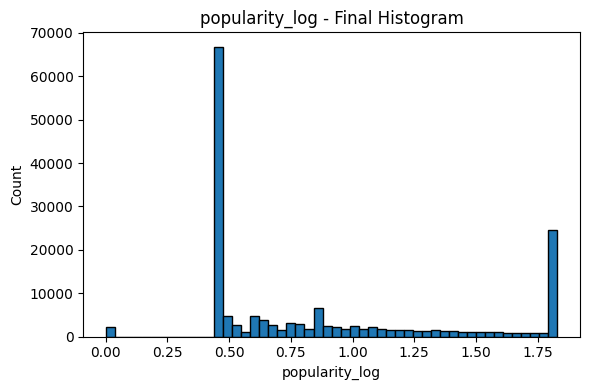

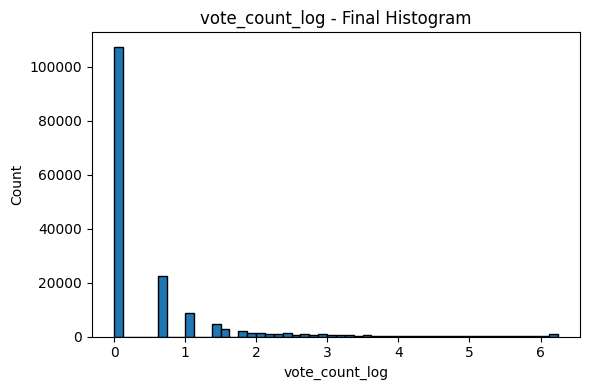

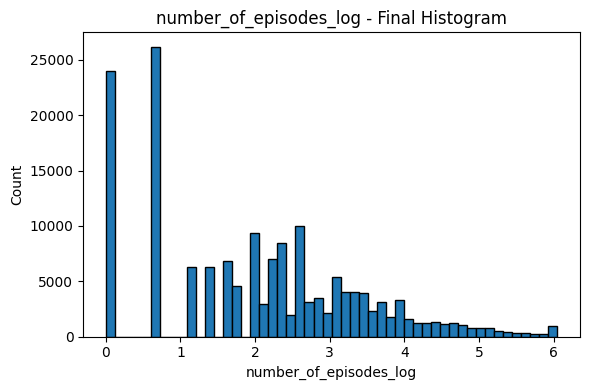

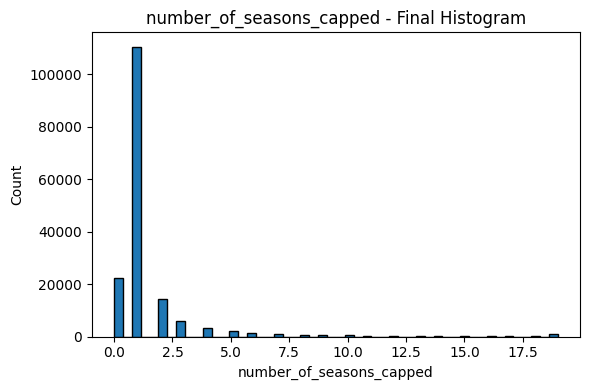

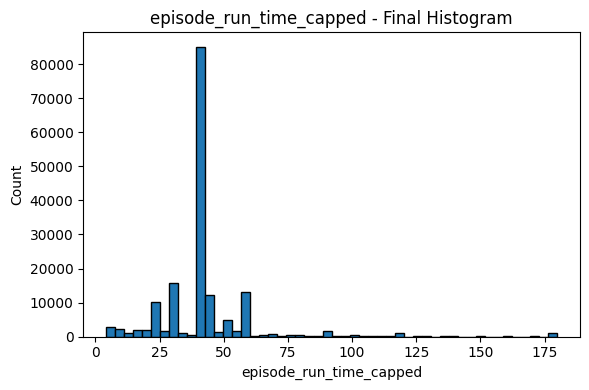

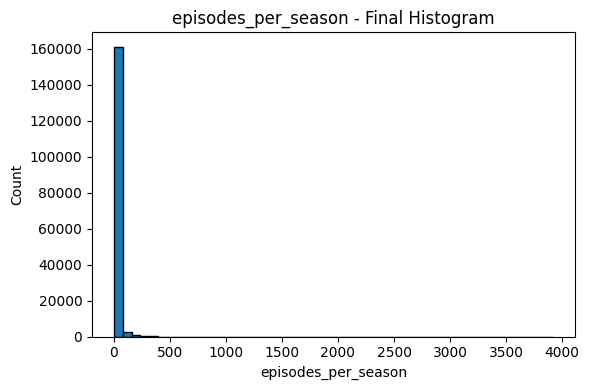

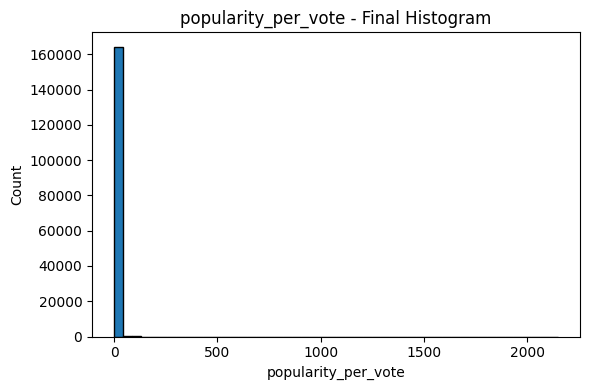

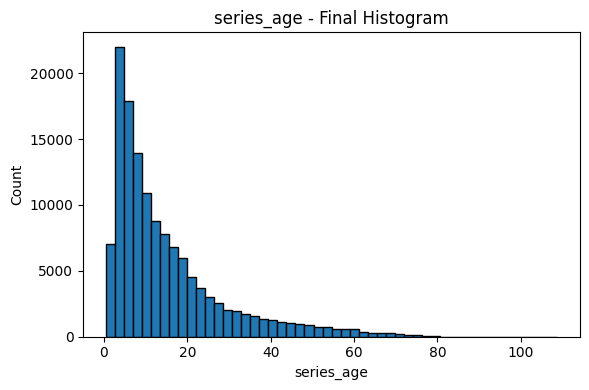

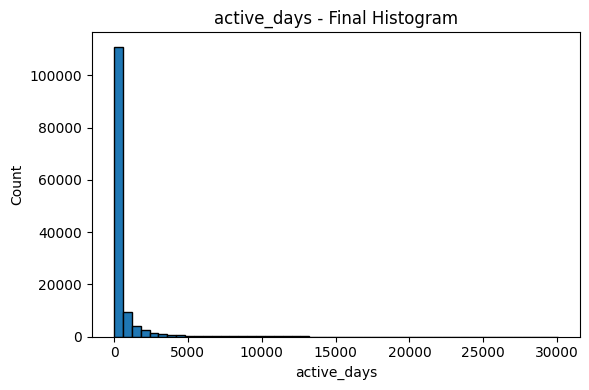


=== Final Boxplots (numeric) ===


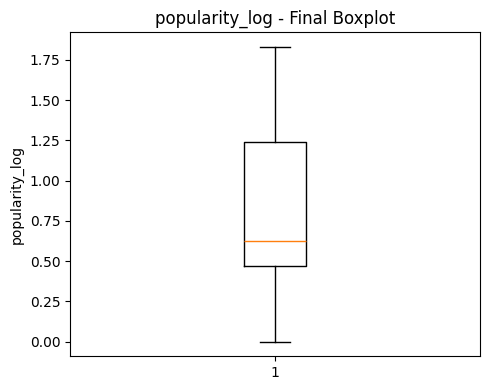

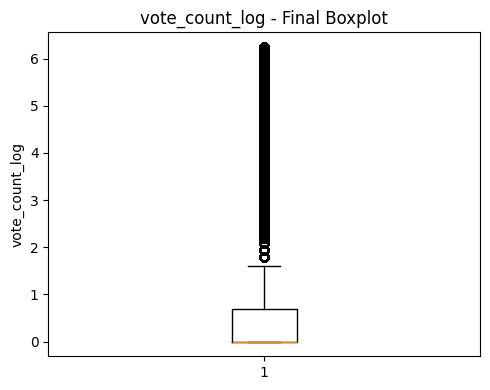

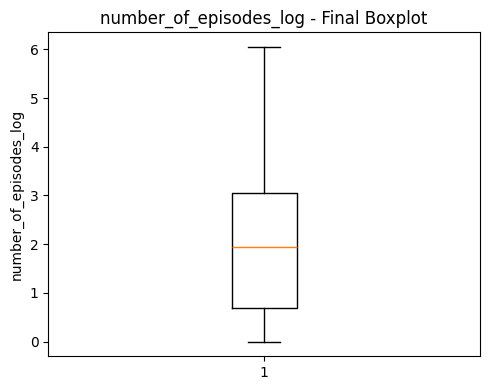

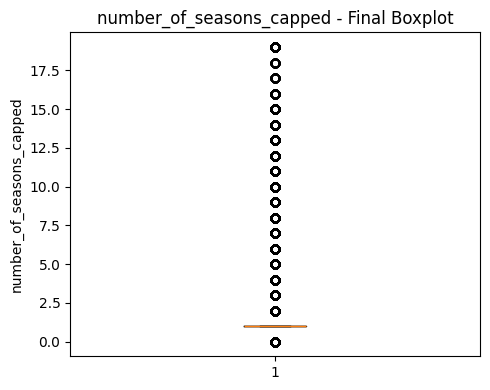

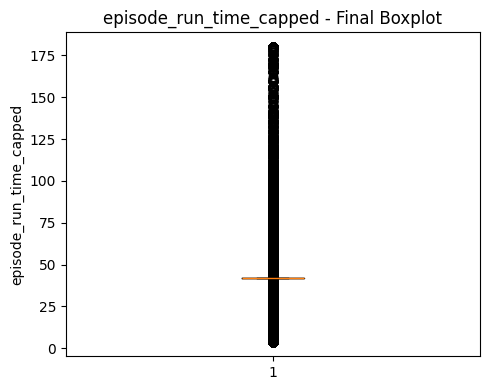

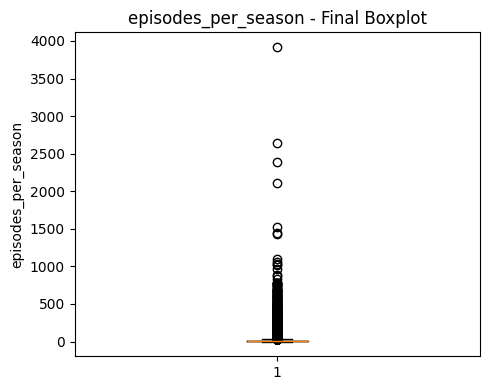

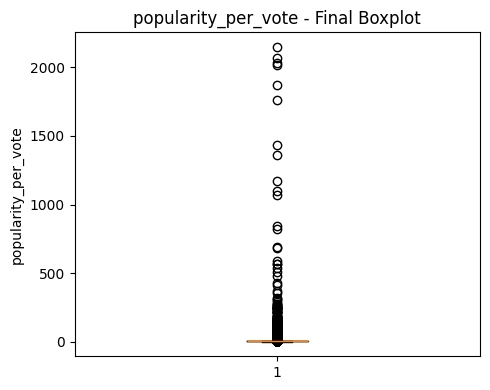

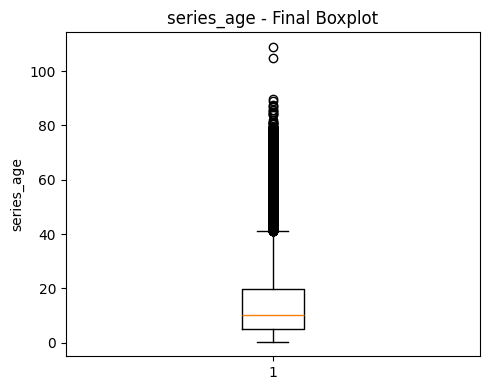

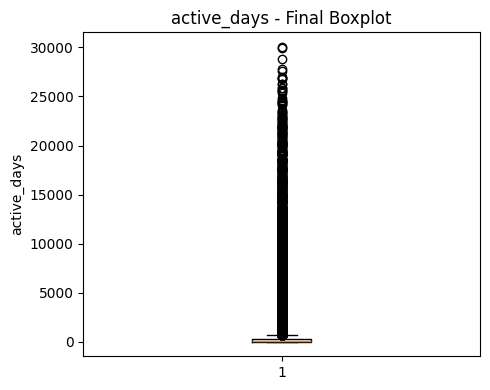


=== Final Bar Charts (categorical, grouped to 'Other') ===


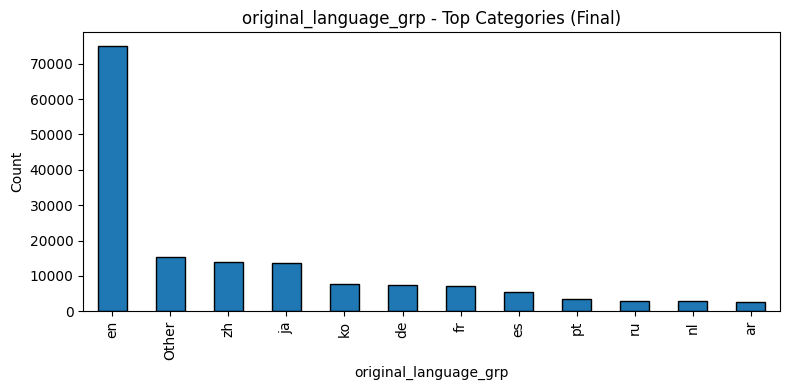

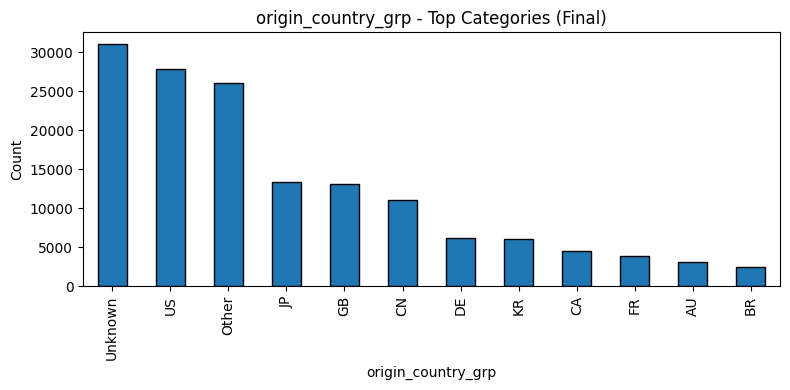

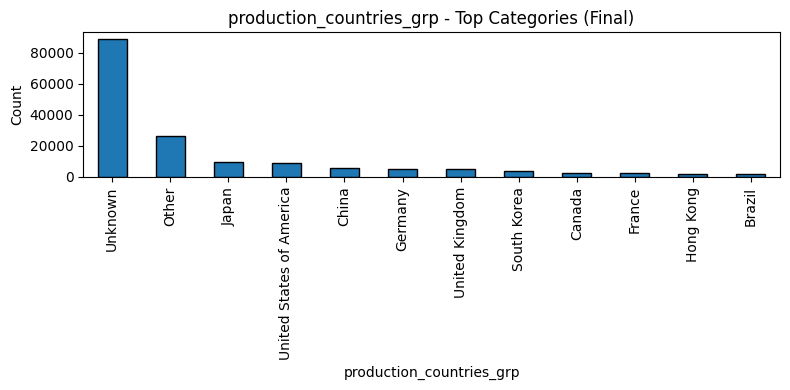

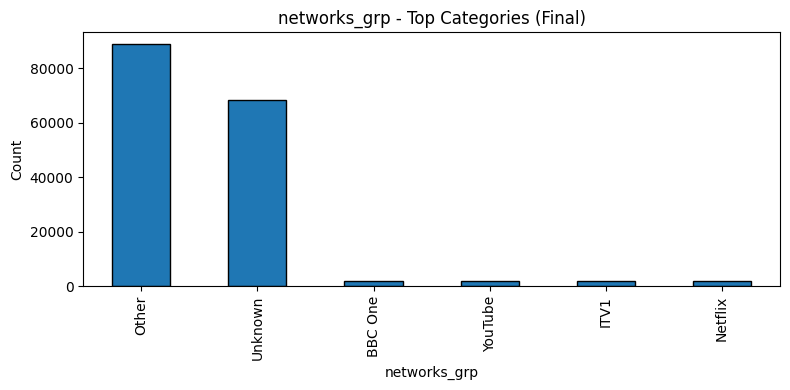

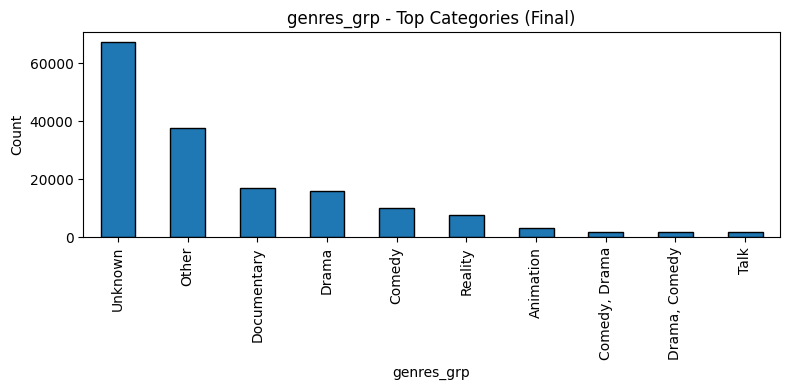


=== Sanity Check: Core Numeric Columns ===
Sanity check passed: No unexpected NaNs in core numeric columns.

✅ Final cleaned dataset exported successfully to:
C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Data Cleansing\tmdb_tv_after_data_cleansing.csv

NOTE:
To produce the 'Data Cleaning & Quality Enhancement Report (PDF)',
export this Jupyter notebook as a PDF (File → Export As → PDF).
All inline visuals and summaries are already included.



In [9]:
#--9--

# Final Checks and Exports
# מטרות:
# • לאמת שלמות נתונים אחרי כל שלבי הניקוי.
# • ויזואליזציה סופית inline (לא שמירת תמונות): היסטוגרמות, בוקספלוטים וגרפים קטגוריים.
# • לוודא שלא נוצרו חסרים חדשים או דליפה (leakage).
# • ייצוא הקובץ הסופי לתיקייה שציינת.

# NOTE:
# This section performs final validation and exports the cleaned dataset
# as "tmdb_tv_after_data_cleansing.csv" to the specified folder path.

# 1) Summary info & statistics -------------------------------------------------
print("=== Final info() ===")
df.info()

print("\n=== Final describe() [numeric columns] ===")
display(df.select_dtypes(include=['number']).describe().T)

print("\n=== Final describe() [object/category columns] ===")
obj_cols = df.select_dtypes(include=['object','category']).columns
if len(obj_cols) > 0:
    display(df[obj_cols].describe().T)
else:
    print("(no object/category columns)")

# 2) Missingness summary -------------------------------------------------------
print("\n=== Final missingness: top 20 (by % NaN) ===")
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.head(20))

total_nans = int(df.isna().sum().sum())
print(f"\nTotal NaNs (final): {total_nans}")

# 3) Visual validation (inline) -----------------------------------------------
# היסטוגרמות ובוקספלוטים לפיצ'רים המרכזיים אחרי הטרנספורמציות
final_num_cols = [
    c for c in [
        'popularity_log', 'vote_count_log', 'number_of_episodes_log',
        'number_of_seasons_capped', 'episode_run_time_capped',
        'episodes_per_season', 'popularity_per_vote', 'series_age', 'active_days'
    ] if c in df.columns
]

print("\n=== Final Histograms (numeric) ===")
for c in final_num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[c].dropna(), bins=50, edgecolor='black')
    plt.title(f"{c} - Final Histogram")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

print("\n=== Final Boxplots (numeric) ===")
for c in final_num_cols:
    plt.figure(figsize=(5,4))
    plt.boxplot(df[c].dropna(), vert=True, showfliers=True)
    plt.title(f"{c} - Final Boxplot")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

# countplots (bar) לעמודות הקטגוריות עם קיבוץ <1% → 'Other'
cat_grp_cols = [
    c for c in ['original_language_grp','origin_country_grp',
                'production_countries_grp','networks_grp','genres_grp']
    if c in df.columns
]
if len(cat_grp_cols) > 0:
    print("\n=== Final Bar Charts (categorical, grouped to 'Other') ===")
    for c in cat_grp_cols:
        plt.figure(figsize=(8,4))
        df[c].value_counts(dropna=False).head(12).plot(kind='bar', edgecolor='black')
        plt.title(f"{c} - Top Categories (Final)")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
else:
    print("\n(No *_grp categorical columns found for bar charts)")

# 4) Leakage / sanity checks ---------------------------------------------------
print("\n=== Sanity Check: Core Numeric Columns ===")
must_be_non_null_if_present = [
    'vote_average', 'episode_run_time',
    'number_of_episodes', 'number_of_seasons', 'popularity', 'vote_count'
]
violations = {}
for c in must_be_non_null_if_present:
    if c in df.columns:
        nn = int(df[c].isna().sum())
        if nn > 0:
            violations[c] = nn

if violations:
    print("[WARNING] Unexpected NaNs found in numeric columns that should have been imputed:")
    print(violations)
else:
    print("Sanity check passed: No unexpected NaNs in core numeric columns.")

# 5) Export final dataset ------------------------------------------------------
export_path = r"C:\Users\user\Desktop\BIU דאטה סיינס\ML\פרויקט 2\פרויקט 2 - סופי\Data Cleansing\tmdb_tv_after_data_cleansing.csv"
df.to_csv(export_path, index=False)
print(f"\n✅ Final cleaned dataset exported successfully to:\n{export_path}")

# 6) Report generation note ----------------------------------------------------
print("""
NOTE:
To produce the 'Data Cleaning & Quality Enhancement Report (PDF)',
export this Jupyter notebook as a PDF (File → Export As → PDF).
All inline visuals and summaries are already included.
""")
